In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15,
    'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

import os, pickle
from pathlib import Path
import numpy as np
import torch
from jarvis.utils import tqdm

rng = np.random.default_rng()
FIG_PATH = Path('../figures')

In [2]:
from bisc import rcParams

# comment out the next two lines if 'stimulus' and 'response' already exist in the repository root folder
rcParams['stimulus_path'] = '/mnt/e/BISC_2023/stimulus'
rcParams['response_path'] = '/mnt/e/BISC_2023/response'

# Compute Fourier spectrum for each valid channel

In [3]:
from bisc.data import get_session, get_stim, get_fs, get_raw_responses, get_num_channels, get_trial_average, get_valid_idxs, align_responses
from numpy.fft import fft, fftshift, fftfreq, ifft

session_id = '62529070'
if session_id=='62529070':
    filename = '../cache/grating.spectrum.pt'
if session_id=='48834689':
    filename = '../cache/dot.spectrum.pt'

session = get_session(session_id)
num_channels = get_num_channels(session)
trial_idxs, channel_idxs = get_valid_idxs(session)
onsets, offsets, _ = get_stim(session)

In [4]:
def get_fourier_amps(session, tic, toc, trial_idxs, cutoff=200):
    onsets, _, _ = get_stim(session)
    num_channels = get_num_channels(session)
    fs = get_fs(session)
    t_len = int(np.floor((toc-tic)/1000*fs))
    freqs = fftfreq(t_len, 1/fs)
    num_freqs = (freqs>cutoff).nonzero()[0][0]
    freqs = freqs[:num_freqs]
    amps = []

    for trial_idx in tqdm(trial_idxs, unit='trial'):
        _tic, _toc = onsets[trial_idx]+tic, onsets[trial_idx]+toc
        responses = get_raw_responses(session, _tic, _toc)[:, :t_len]
        amps.append(np.abs(fft(responses, axis=1)[:, :num_freqs]))
    amps = np.stack(amps, axis=1)/(toc-tic)**0.5
    return freqs, amps

if os.path.exists(filename):
    saved = torch.load(filename)
    freqs_pre, amps_pre = saved['freqs_pre'], saved['amps_pre']
    freqs_stim, amps_stim = saved['freqs_stim'], saved['amps_stim']
else:
    freqs_pre, amps_pre = get_fourier_amps(session, -300, 0, trial_idxs)
    freqs_stim, amps_stim = get_fourier_amps(session, 300, 1500, trial_idxs)
    torch.save({
        'session_id': session_id, 'channel_idxs': channel_idxs,
        'freqs_pre': freqs_pre, 'amps_pre': amps_pre,
        'freqs_stim': freqs_stim, 'amps_stim': amps_stim,
    }, filename)

Spectrum comparison for individual channels


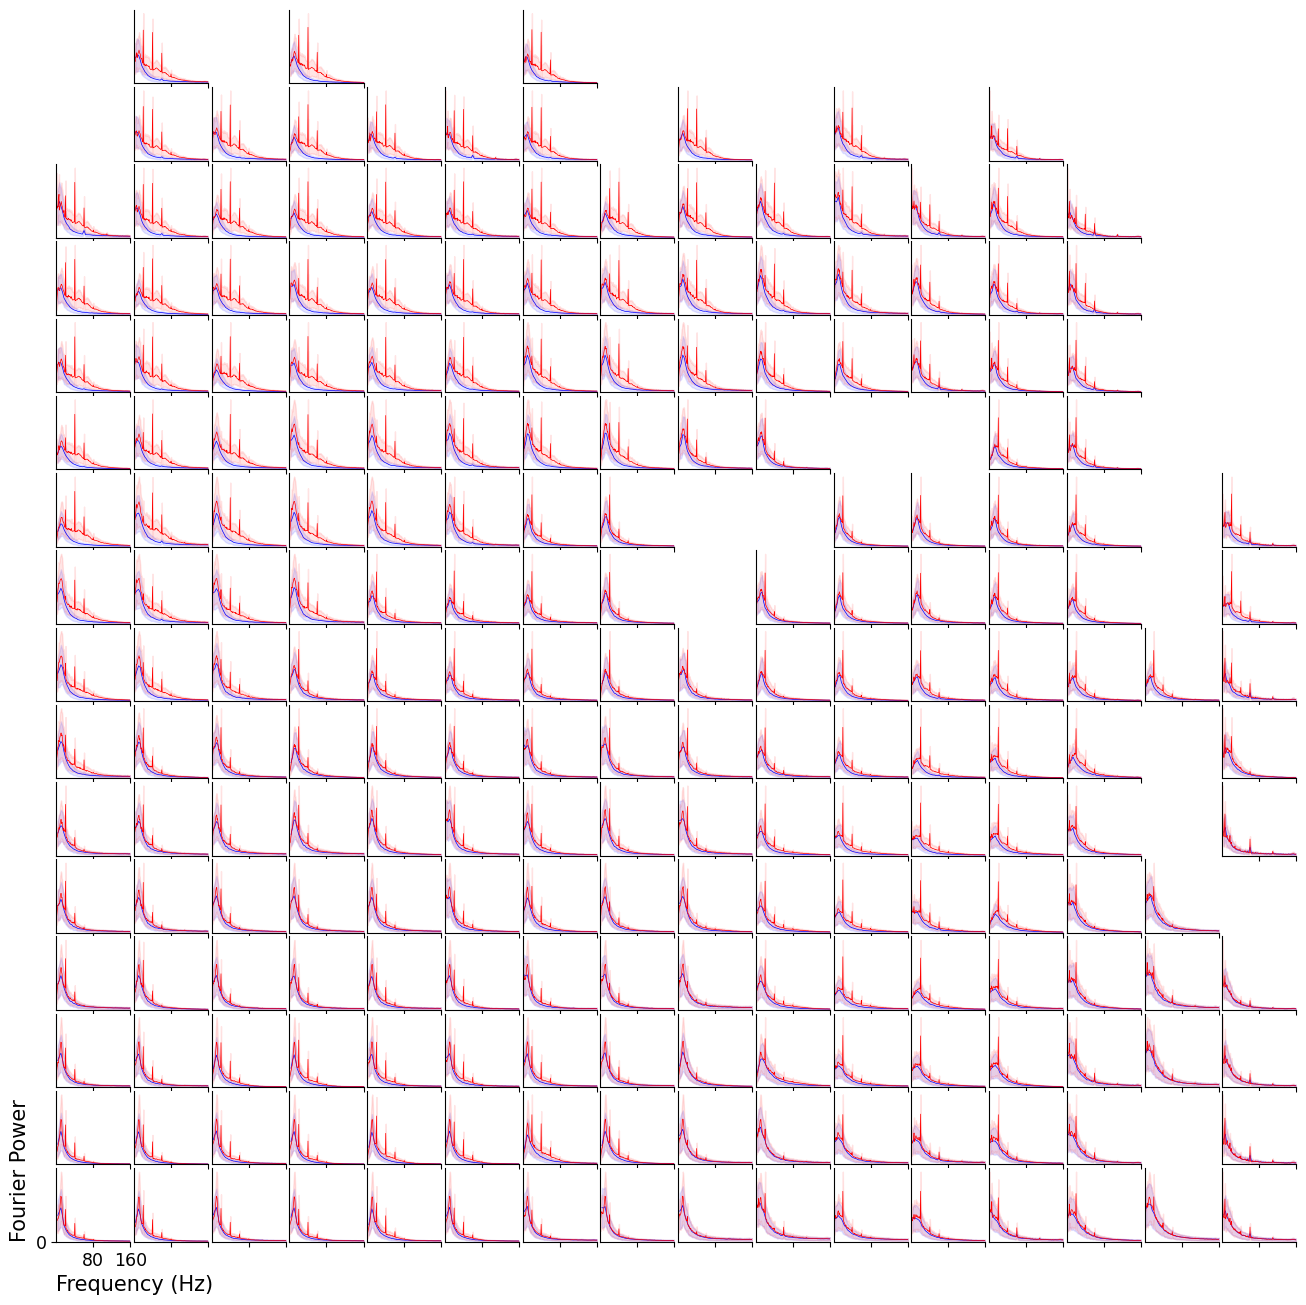

In [5]:
print('Spectrum comparison for individual channels')

fig, axes = plt.subplots(16, 16, figsize=(16, 16), gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
for channel_idx, ax in enumerate(axes.ravel()):
    if channel_idx not in channel_idxs:
        ax.axis('off')
        continue
    lines = []
    for freqs, amps, color in zip(
        [freqs_pre, freqs_stim],
        [amps_pre[channel_idx], amps_stim[channel_idx]],
        ['blue', 'red'],
    ):
        v_mean = amps.mean(axis=0)
        v_std = amps.std(axis=0)
        v_mean[0] = np.nan
        h, = ax.plot(freqs, v_mean, color=color, linewidth=0.5)
        lines.append(h)
        ax.fill_between(freqs, v_mean-v_std, v_mean+v_std, alpha=0.1, color=color)
    ax.set_xticks([80, 160])
    ax.set_xlim([0, 160])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_ylim([0, None])
ax = axes[-1, 0]
ax.set_xticklabels([80, 160])
ax.set_xlabel('Frequency (Hz)', loc='left')
ax.set_yticks([0])
ax.set_ylabel('Fourier Power', loc='bottom')
# fig.savefig(FIG_PATH/f'spectrum.comparison_all.channels_{session_id}.svg')

plt.show()

## Summarize all channels

Amplitude change for valid channels


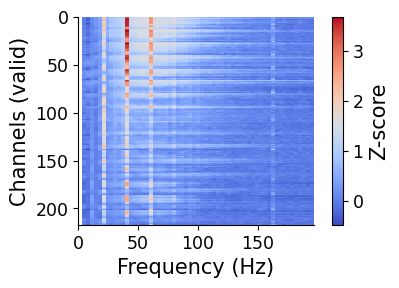

Fractions of changed frequency


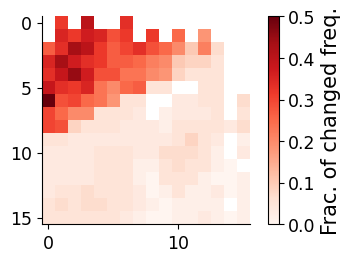

In [6]:
amps_diff = amps_stim[..., ::4]-amps_pre
zs = amps_diff.mean(axis=1)/amps_diff.std(axis=1)
zs[:, 0] = np.nan

print('Amplitude change for valid channels')
fig, ax = plt.subplots()
h = ax.imshow(zs[channel_idxs], extent=[0, freqs_pre.max(), len(channel_idxs), 0], cmap='coolwarm', aspect=0.8, interpolation='nearest')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Channels (valid)')
plt.colorbar(h, label='Z-score')
# fig.savefig(FIG_PATH/f'Fourier.power.change_{session_id}.svg')

plt.show()

fractions = np.nanmean(np.abs(zs)>1, axis=1)
for channel_idx in range(256):
    if channel_idx not in channel_idxs:
        fractions[channel_idx] = np.nan
fractions = fractions.reshape(16, 16)

print('Fractions of changed frequency')
fig, ax = plt.subplots()
h = ax.imshow(fractions, vmin=0, cmap='Reds')
plt.colorbar(h, label='Frac. of changed freq.')
# fig.savefig(FIG_PATH/f'frequency.change.fraction_{session_id}.svg')

plt.show()

Averaged spectrum of significantly changed channels


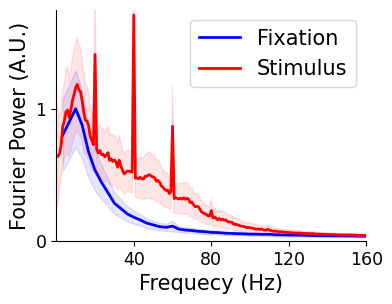

In [7]:
mask = (fractions>0.1).reshape(-1)

print('Averaged spectrum of significantly changed channels')
fig, ax = plt.subplots(figsize=(4, 3))
v_scale = amps_pre[mask].mean(axis=(0, 1))[1:].max()
lines = []
for freqs, amps, color in zip([freqs_pre, freqs_stim], [amps_pre, amps_stim], ['blue', 'red']):
    v_mean = amps[mask].mean(axis=(0, 1))/v_scale
    v_std = amps[mask].mean(axis=1).std(axis=0)/v_scale
    v_mean[0] = np.nan
    h, = ax.plot(freqs, v_mean, color=color)
    lines.append(h)
    ax.fill_between(freqs, v_mean-v_std, v_mean+v_std, alpha=0.1, color=color)
ax.set_xticks([40, 80, 120, 160, 200])
ax.set_xlabel('Frequecy (Hz)')
ax.set_ylabel('Fourier Power (A.U.)')
ax.legend(lines, ['Fixation', 'Stimulus'], fontsize='medium')
ax.set_xlim([0, 160])
ax.set_ylim([0, 1.75])
ax.set_yticks([0, 1])
# fig.savefig(FIG_PATH/f'spectrum.comparison_significant.channels_{session_id}.svg')

plt.show()

# Filtered response during one trial

In [8]:
trial_idx = 100

tic, toc = onsets[trial_idx]-300, offsets[trial_idx]+300
responses = get_raw_responses(session, tic, toc)
fs = get_fs(session)
taus = np.arange(responses.shape[1])/fs*1000+tic-onsets[trial_idx]
freqs = fftfreq(len(taus), 1/fs)
ys = fft(responses, axis=1)
ys[:, (np.abs(freqs)<20)|(np.abs(freqs)>90)] = 0
xs = np.real(ifft(ys, axis=1))

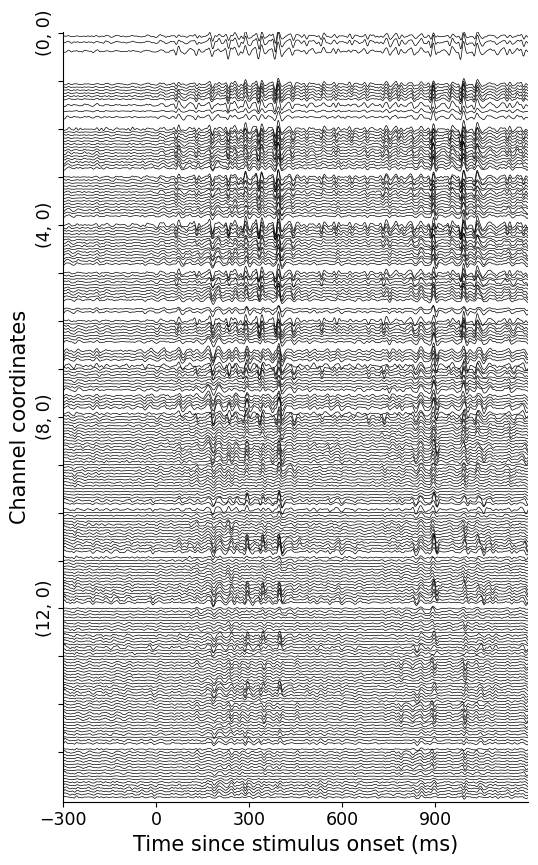

In [9]:
fig, ax = plt.subplots(figsize=(6, 10))
gap = 15
for channel_idx in channel_idxs:
    ax.plot(taus, xs[channel_idx]-channel_idx*gap, linewidth=0.5, color='k')
ax.set_xlim([-300, 1200])
ax.set_xticks([-300, 0, 300, 600, 900])
ax.set_xlabel('Time since stimulus onset (ms)')
ax.set_yticks(-np.arange(16)*16*gap)
ax.set_yticklabels(['(0, 0)', '', '', '', '(4, 0)', '', '', '', '(8, 0)', '', '', '', '(12, 0)', '', '', ''], rotation=90, va='center')
ax.set_ylim([-256.5*gap, 0.5*gap])
ax.set_ylabel('Channel coordinates')
# fig.savefig(FIG_PATH/f'filtered.signal_{session_id}.svg')

plt.show()

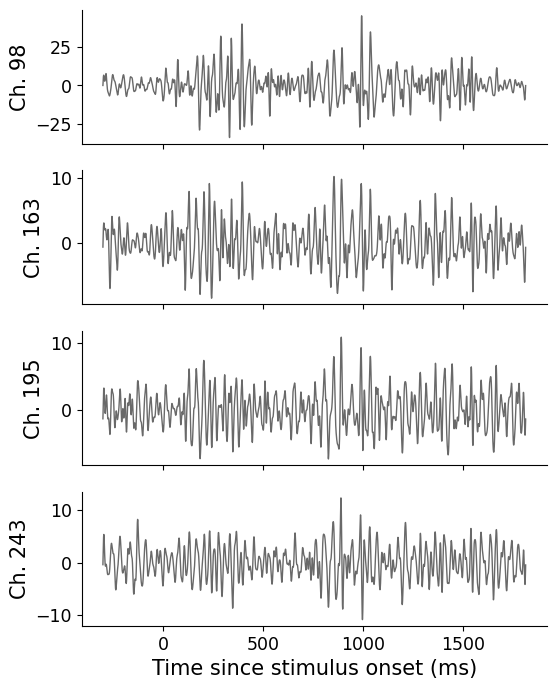

In [10]:
to_plot = sorted(rng.choice(channel_idxs, 4, replace=False))

fig, axes = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(taus, xs[to_plot[i]], linewidth=1, color='dimgray')
    ax.set_ylabel(f'Ch. {to_plot[i]}')
ax.set_xlabel('Time since stimulus onset (ms)')
# fig.savefig(FIG_PATH/f'filtered.signal.examples_{session_id}.svg')

plt.show()